In [1]:
import pandas as pd

record = pd.read_csv('./result/pre_train/cnn_audio-mnist_record.csv')
record.head()

,Unnamed: 0,type,step,accuracy,loss
0,0,train,0,12.5000,2.301594
1,1,train,1,7.8125,2.308034
2,2,train,2,14.0625,2.299752
3,3,train,3,18.7500,2.298266
4,4,train,4,6.2500,2.299567


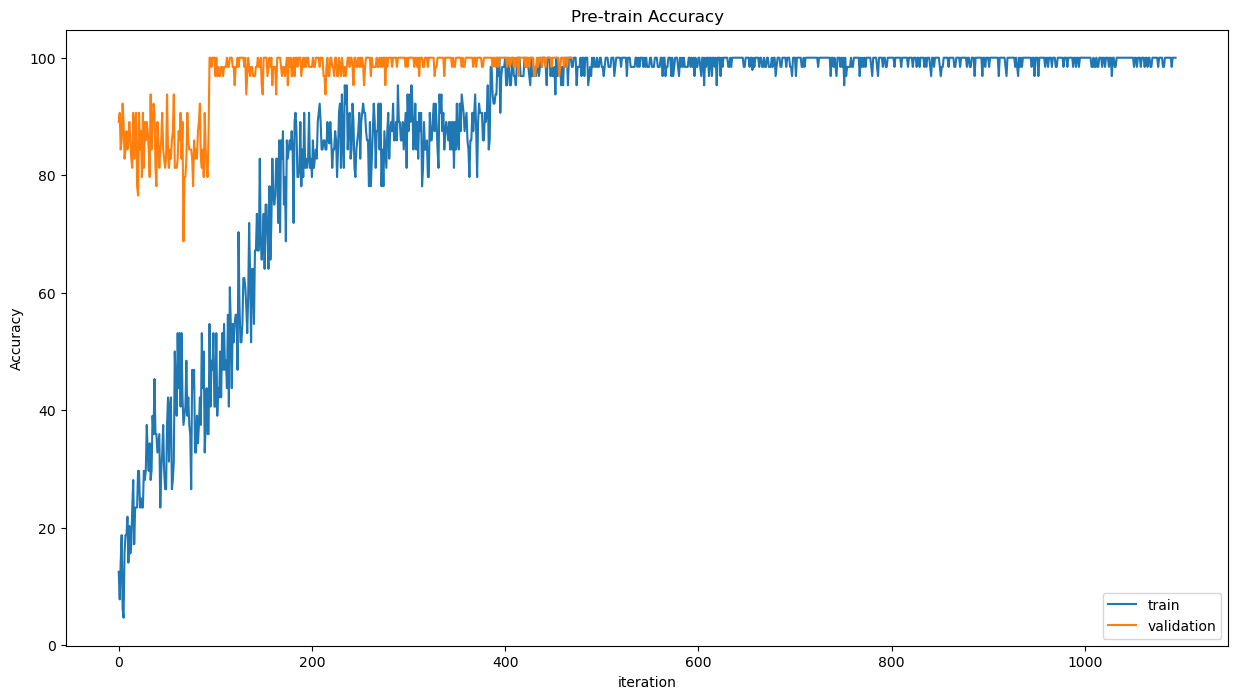

In [2]:
import matplotlib.pyplot as plt

train_record = record[record['type'] == 'train']
val_record = record[record['type'] == 'validation']
plt.figure(figsize=(15, 8))
plt.plot(train_record['step'], train_record['accuracy'], label='train')
plt.plot(val_record['step'], val_record['accuracy'], label='validation')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.title('Pre-train Accuracy')
plt.legend(loc='lower right')
plt.show()

In [3]:
from lib.datasets import AudioMINST, load_datapath
from lib.wavUtils import Components, pad_trunc, time_shift, GuassianNoise
from lib.models import WavClassifier
import torch 
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

sample_rate = 48000
data_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=sample_rate),
    GuassianNoise(noise_level=.025),
    # time_shift(shift_limit=.1),
    transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, n_mels=64),
    transforms.AmplitudeToDB(top_db=80),
    # transforms.FrequencyMasking(freq_mask_param=.1),
    # transforms.TimeMasking(time_mask_param=.1)
])
test_datapathes = load_datapath(root_path='/root/data/AudioMNIST/data', filter_fn=lambda x: x['accent']!= 'German')
test_dataset = AudioMINST(data_paths=test_datapathes, include_rate=False, data_trainsforms=data_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WavClassifier(class_num=10, l1_in_features=64, c1_in_channels=1).to(device=device)
model.load_state_dict(torch.load('result/pre_train/cnn_audio-mnist.pt'))
test_accu = 0.
test_iter = iter(test_loader)
for iteration in tqdm(range(len(test_loader))):
    inputs, labels = next(test_iter)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    test_accu += (preds == labels).sum().cpu().item()
test_accu = test_accu / len(test_dataset) * 100.
print(f'test_accu: {test_accu:.2f}')

100%|██████████| 157/157 [01:18<00:00,  1.99it/s]

test_accu: 23.25
